- refactor the files... e.g. simulation code split between standard DGPs and code that makes data, rename hte_caret, move iptw/ipcw to different places
- implement value and c-index functions. (remember: ipcw is needed b/c KM by itself doesn't adjust for *informative* censoring)
- test everything together
- run sims and look at results

In [2]:
library(plyr)
library(magrittr)
library(distr)
library(distrEx)
library(gbm)
library(Matching)
library(caret)
library(tidyverse)
source("R/simulation_scenarios.R")
source("R/hte_caret.R")
source("R/eval_hte_cv.R")
source("R/hte_cv.R")

In [3]:
DGP = list()
n = 5

X1 = Norm(-1)
X2 = Norm(1)
DGP$X = list(X1, X2)

DGP$f_W_x = function(x, w) {
    logit_p = x[1] + x[2]
    p = exp(logit_p) / (1 + exp(logit_p))
    Binom(prob=p)
}

DGP$f_Y_xw = function(x, w) {
    if(w) {
        Weibull(scale=abs(x[1] + x[2]) + 0.7, 
                shape=1.2)
    } else {
        Weibull(scale= abs(x[1]) + abs(x[2]), 
                shape=1.5)
    }
}

DGP$f_C_xw = function(x, w) {
    Weibull(scale=4, 
            shape=1.4)
}

In [4]:
datas = setup_data(DGP, 1000, 500, 5)

Warning message:
: package ‘bindrcpp’ was built under R version 3.2.5

In [5]:
models = list(
    gbm_spec = list(method = "gbm",
                tune_grid = expand.grid(n.trees = seq(1,501,20), 
                                        interaction.depth=3, 
                                        shrinkage = 0.2, 
                                        n.minobsinnode=3)))
estimates = datas %$% get_estimates(data, models, cv_index, test_index)

In [6]:
metrics =  estimates %$% get_metrics(cv_estimates, test_estimates, datas$aux_data) 

Warning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vectorWarning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vectorWarning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vectorWarning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vector

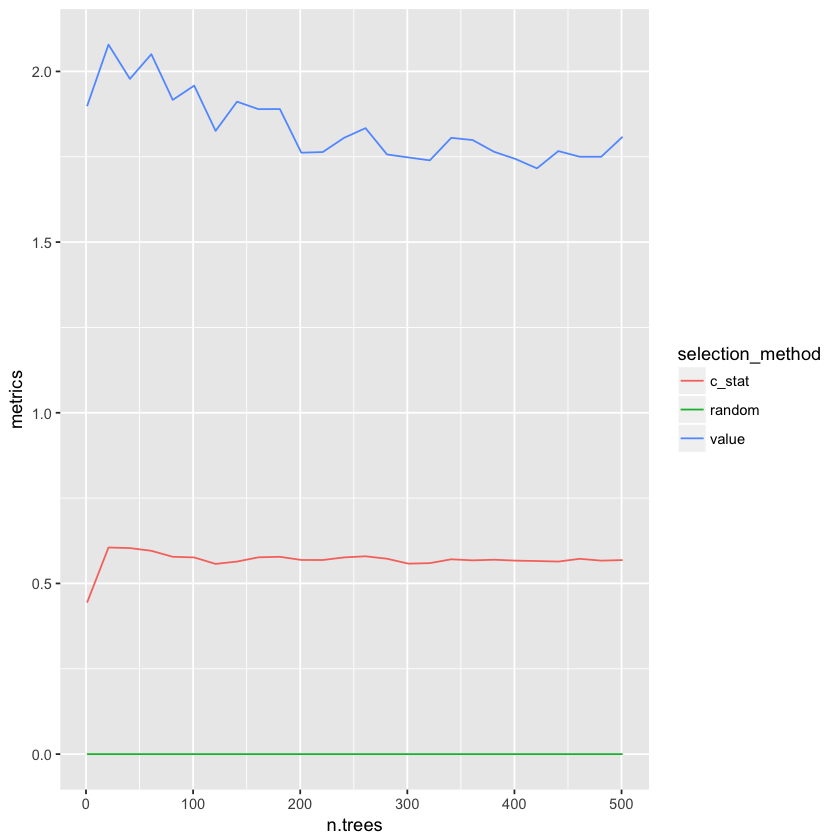

In [7]:
metrics$cv_metrics %>%
    separate(model, c(models$gbm_spec$method, names(models$gbm_spec$tune_grid)), sep="~") %>%
    mutate(n.trees = as.numeric(n.trees)) %>%
# data.frame %>% str
ggplot(aes(x=n.trees, y=metrics, color=selection_method)) + 
    geom_line()

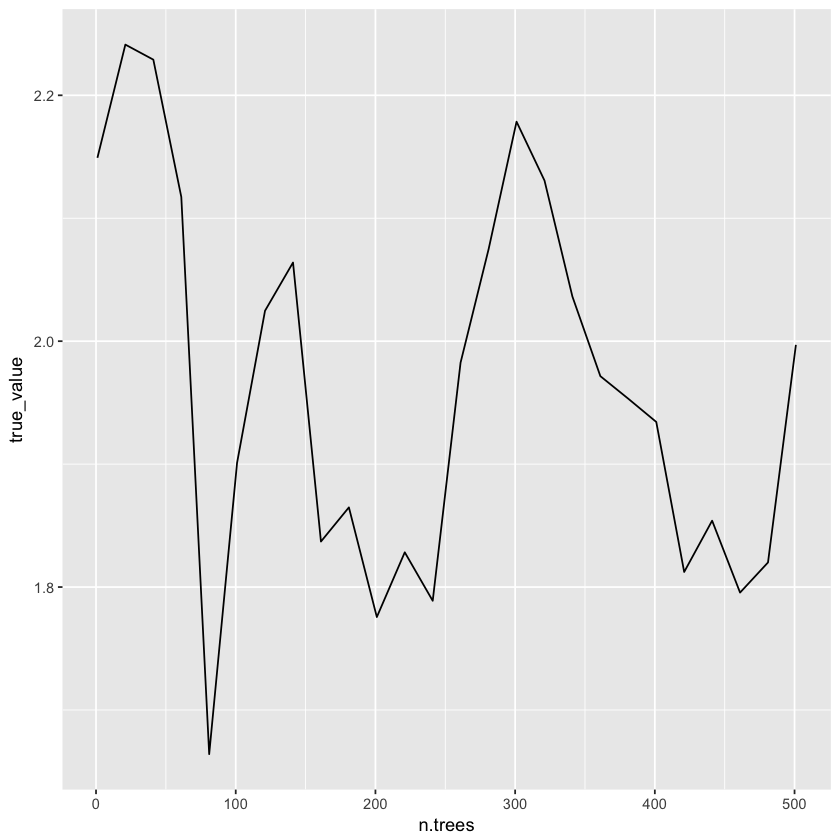

In [8]:
metrics$test_metrics %>%
    separate(model, c(models$gbm_spec$method, names(models$gbm_spec$tune_grid)), sep="~") %>%
    mutate(n.trees = as.numeric(n.trees)) %>%
# data.frame %>% str
ggplot(aes(x=n.trees, y=true_value)) + 
    geom_line()

In [9]:
metrics$true_selection_metrics %>% data.frame

,model,selection_method,true_value
1,gbm~21~3~0.2~3,c_stat,2.241235
2,gbm~41~3~0.2~3,random,2.229011
3,gbm~21~3~0.2~3,value,2.241235
4,gbm~21~3~0.2~3,oracle_selector_true_value,2.241235
5,truth,oracle,2.312365
6,harm,demon,1.414023
